In [276]:
from pathlib import Path
from multiprocessing import Pool
import logging

import click
import pandas as pd
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import tifffile as tif
import os

## Image folder locations

In [114]:
input_image_folder = "../../datasets/ADDA/resampled/images/"
input_label_folder = "../../datasets/ADDA/resampled/labels/"
output_image_folder = "../dataset/images_resampled/"
output_label_folder = "../dataset/labels_resampled/"

In [115]:
input_image_folder = Path(input_image_folder).resolve()
input_label_folder = Path(input_label_folder).resolve()
output_image_folder = Path(output_image_folder).resolve()
output_label_folder = Path(output_label_folder).resolve()

In [121]:
# get names of all images (patients)
patient_list = [
        f.name.split("__")[0] for f in input_image_folder.rglob("*_CT*")
    ]

if len(patient_list) == 0:
    raise ValueError("No patient found in the input folder")

len(patient_list)

270

## Extract number of positives for each patient

In [314]:
# empty dictionary to store num of positive slices
num_positives = []
images_dict = dict()

for i, p in enumerate(patient_list):
    # if i==5:
    #     break
    print(i, p)
    img = nib.load(str([f for f in input_label_folder.rglob(p + "*")][0]))
    # Get the NIfTI image data as a NumPy array
    img_data = img.get_fdata()
    img_data.shape
    # Find non-black slices
    non_black_slices = []
    for i in range(img_data.shape[-1]):
        slice_data = img_data[..., i]
        if np.any(slice_data ==1):  # Change the condition as needed
            non_black_slices.append(i)
    num_positives.append(len(non_black_slices))
    print(len(non_black_slices))
    # add info to images_dict
    images_dict[p] = non_black_slices
    
    

0 MDA-111
25
1 MDA-126
49
2 MDA-005
43
3 MDA-032
33
4 MDA-173
42
5 MDA-144
16
6 MDA-067
34
7 MDA-050
33
8 MDA-098
52
9 CHUP-028
36
10 MDA-019
33
11 MDA-158
23
12 CHUP-056
26
13 MDA-190
53
14 CHUP-061
18
15 MDA-084
43
16 CHUP-034
24
17 CHUP-003
12
18 CHUP-012
30
19 CHUP-025
34
20 MDA-095
29
21 CHUP-070
30
22 CHUP-047
51
23 MDA-181
39
24 MDA-149
62
25 CHUP-039
48
26 MDA-089
22
27 MDA-041
49
28 MDA-076
42
29 MDA-155
42
30 MDA-162
36
31 MDA-023
10
32 MDA-014
26
33 MDA-137
36
34 MDA-100
46
35 MDA-058
39
36 MDA-119
15
37 CHUP-020
41
38 CHUP-017
48
39 CHUP-042
63
40 MDA-184
39
41 CHUP-075
18
42 MDA-090
23
43 MDA-167
29
44 MDA-150
23
45 MDA-073
49
46 MDA-044
49
47 MDA-105
20
48 MDA-132
33
49 MDA-011
27
50 MDA-026
26
51 CHUP-069
41
52 MDA-198
26
53 MDA-189
29
54 MDA-037
62
55 MDA-123
33
56 MDA-114
59
57 MDA-055
23
58 MDA-062
29
59 MDA-141
39
60 MDA-176
55
61 MDA-081
13
62 CHUP-064
42
63 CHUP-053
36
64 MDA-195
35
65 CHUP-006
42
66 MDA-108
10
67 MDA-049
52
68 MDA-138
63
69 MDA-079
17
70 CHUP-063


## Calculate average number of positive slices in dataset

In [315]:

count=0
for k,v in images_dict.items():
    print(k, len(v))
    count+=len(v)
count/len(images_dict.keys())
    

MDA-111 25
MDA-126 49
MDA-005 43
MDA-032 33
MDA-173 42
MDA-144 16
MDA-067 34
MDA-050 33
MDA-098 52
CHUP-028 36
MDA-019 33
MDA-158 23
CHUP-056 26
MDA-190 53
CHUP-061 18
MDA-084 43
CHUP-034 24
CHUP-003 12
CHUP-012 30
CHUP-025 34
MDA-095 29
CHUP-070 30
CHUP-047 51
MDA-181 39
MDA-149 62
CHUP-039 48
MDA-089 22
MDA-041 49
MDA-076 42
MDA-155 42
MDA-162 36
MDA-023 10
MDA-014 26
MDA-137 36
MDA-100 46
MDA-058 39
MDA-119 15
CHUP-020 41
CHUP-017 48
CHUP-042 63
MDA-184 39
CHUP-075 18
MDA-090 23
MDA-167 29
MDA-150 23
MDA-073 49
MDA-044 49
MDA-105 20
MDA-132 33
MDA-011 27
MDA-026 26
CHUP-069 41
MDA-198 26
MDA-189 29
MDA-037 62
MDA-123 33
MDA-114 59
MDA-055 23
MDA-062 29
MDA-141 39
MDA-176 55
MDA-081 13
CHUP-064 42
CHUP-053 36
MDA-195 35
CHUP-006 42
MDA-108 10
MDA-049 52
MDA-138 63
MDA-079 17
CHUP-063 40
MDA-192 0
CHUP-054 27
MDA-086 49
CHUP-001 29
CHUP-036 27
MDA-124 0
MDA-113 25
MDA-030 23
MDA-007 28
MDA-146 39
MDA-171 29
MDA-052 39
MDA-065 39
CHUP-048 26
CHUP-059 46
MDA-074 34
MDA-043 46
MDA-160 13

34.5

In [218]:
# images_dict['MDA-079']

In [220]:
# len(images_dict['MDA-017'])

121

## Load and save images as Tiff stack

In [231]:
def apply_window(img, width=500, center=40):
    # np.interp(a, (a.min(), a.max()), (-1, +1))

    # convert below window to black
    img[img<(center-(width/2))]=center-(width/2)
    # convert above window to white
    img[img>(center+(width/2))]=center+(width/2)

    # normalize image
    img_scaled = np.interp(img, (img.min(), img.max()), (0, +1))
    # print(img_scaled.shape)
    # print(np.min(img_scaled), np.max(img_scaled))
    return img

In [273]:
i = 0
n = 100
for k,v in images_dict.items():
    # if k != 'CHUP-058':
    #     # print('skipping', k)
    #     continue

    print(f'{i} - working on {k}')
    
    # select one image 
    img_name = k
    slices_to_save = v
    print(f'{k} has {len(v)} positive slices')
    # load the image
    ct = nib.load(str(input_image_folder)+f'/{k}__CT.nii.gz')
    ct = ct.get_fdata()

    pt = nib.load(str(input_image_folder)+f'/{k}__PT.nii.gz')
    pt = pt.get_fdata()

    msk = nib.load(str(input_label_folder)+f'/{k}.nii.gz')
    msk = msk.get_fdata()

    print(ct.shape, pt.shape, msk.shape)
    print(f'positive slices are between {min(v)} and {max(v)} total is {len(v)}')

    orig_first = min(v)
    orig_last = max(v)

    median = v[len(v) // 2]
    print(orig_first, orig_last, median)
    print('saving from ',  median-(n//2), 'to ',median+(n//2))

    # ensure slices are within bounds
    max_idx = ct.shape[2]
    min_idx = 0

    # if theres not enough slices
    if (median+(n//2) > max_idx) or (median-(n//2) < min_idx):
        
        final_ct = apply_window(ct[:,:,median-(n//2)-3:median+(n//2)])
        final_pt = pt[:,:,median-(n//2)-3:median+(n//2)]
        final_mask = msk[:,:,median-(n//2)-3:median+(n//2)]
        # just keep gtv
        final_mask = (final_mask == 1)
        
    else:
    
        final_ct = apply_window(ct[:,:,median-(n//2):median+(n//2)])
        final_pt = pt[:,:,median-(n//2):median+(n//2)]
        final_mask = msk[:,:,median-(n//2):median+(n//2)]
        # just keep gtv
        final_mask = (final_mask == 1)
    
    print(final_ct.shape, final_pt.shape, final_mask.shape, '\n')
    

    with open('./logs/success_tiff.txt', 'a') as f:
            f.write(f'{i} --- {k} has {len(v)} positive slices\n')
            f.write(f'{i} --- ct {ct.shape}, pt {pt.shape}, mask {msk.shape}\n')
            f.write(f'{i} --- positive slices are between {min(v)} and {max(v)} total is {len(v)}\n')
            f.write(f'{i} --- saving from {median-(n//2)} to {median+(n//2)}\n\n')

    if (median+(n//2) > max_idx) or (median-(n//2) < min_idx):
        with open('./logs/fail_tiff.txt', 'a') as f:
            f.write(f'{i} --- {k} has {len(v)} positive slices\n')
            f.write(f'{i} --- ct {ct.shape}, pt {pt.shape}, mask {msk.shape}\n')
            f.write(f'{i} --- positive slices are between {min(v)} and {max(v)} total is {len(v)}\n')
            f.write(f'{i} --- saving from {median-(n//2)} to {median+(n//2)}\n\n')
        print('failed....')
        continue

    # Open a TiffWriter object
    tif.imwrite(f'../dataset/tiff/images/{img_name}__CT.tiff', final_ct)
    tif.imwrite(f'../dataset/tiff/images/{img_name}__PT.tiff', final_pt)
    tif.imwrite(f'../dataset/tiff/labels/{img_name}.tiff', final_mask)
    
    # break
    # if i==10:
    #     break
    i+=1

0 - working on MDA-111
MDA-111 has 40 positive slices
(500, 500, 975) (500, 500, 975) (500, 500, 975)
positive slices are between 813 and 852 total is 40
813 852 833
saving from  783 to  883
(500, 500, 100) (500, 500, 100) (500, 500, 100) 

1 - working on MDA-126
MDA-126 has 59 positive slices
(500, 500, 415) (500, 500, 415) (500, 500, 415)
positive slices are between 156 and 214 total is 59
156 214 185
saving from  135 to  235
(500, 500, 100) (500, 500, 100) (500, 500, 100) 

2 - working on MDA-005
MDA-005 has 131 positive slices
(500, 500, 873) (500, 500, 873) (500, 500, 873)
positive slices are between 574 and 704 total is 131
574 704 639
saving from  589 to  689
(500, 500, 100) (500, 500, 100) (500, 500, 100) 

3 - working on MDA-032
MDA-032 has 33 positive slices
(498, 498, 873) (498, 498, 873) (498, 498, 873)
positive slices are between 646 and 678 total is 33
646 678 662
saving from  612 to  712
(498, 498, 100) (498, 498, 100) (498, 498, 100) 

4 - working on MDA-173
MDA-173 has

## Preview output

(500, 500, 100) (500, 500, 100) (500, 500, 100)


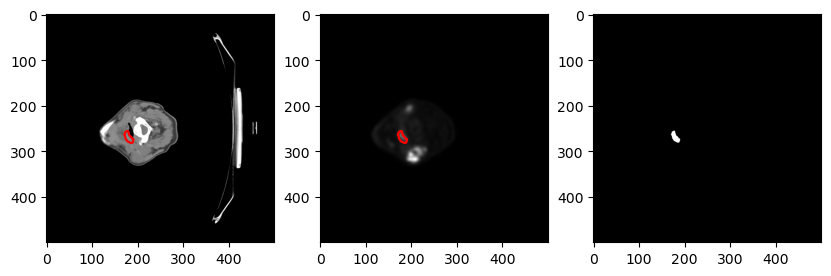

In [313]:
import tifffile as tif
import matplotlib.pyplot as plt

# Open the TIFF file
ct = tif.imread('../../datasets/ADDA/tiff/images/MDA-175__CT.tiff')
pet = tif.imread('../../datasets/ADDA/tiff/images/MDA-175__PT.tiff')
mask = tif.imread('../../datasets/ADDA/tiff/labels/MDA-175.tiff')

print(ct.shape, pet.shape, mask.shape)
slice = 70
# Display the image
fig, ax = plt.subplots(ncols=3, figsize=(10,10))
ax[0].imshow(ct[:,:,slice], cmap='gray')
ax[0].contour(mask[:,:,slice], colors='red')
ax[1].imshow(pet[:,:,slice], cmap='gray')
ax[1].contour(mask[:,:,slice], colors='red')
ax[2].imshow(mask[:,:,slice], cmap='gray')
plt.show()


## Create Dataframes

we already created the test/train/valid split we just need to rename the files in the csv file

In [286]:
def add_tiff(df):
    df['ct_image'] = df['ct_image'].apply(lambda x: x.replace('.nii.gz', '.tiff'))
    df['pt_image'] = df['pt_image'].apply(lambda x: x.replace('.nii.gz', '.tiff'))
    df['label'] = df['label'].apply(lambda x: x.replace('.nii.gz', '.tiff'))
    return df

In [280]:
# replace .nii.gz to .tiff
tiff_path = '../../datasets/ADDA/tiff/'

In [288]:
source_train = pd.read_csv(os.path.join(tiff_path, 'source_train.csv'))
source_valid = pd.read_csv(os.path.join(tiff_path, 'source_valid.csv'))
source_test = pd.read_csv(os.path.join(tiff_path, 'source_test.csv'))


In [289]:
source_train = add_tiff(source_train)
source_valid  = add_tiff(source_valid)
source_test  = add_tiff(source_test)

In [293]:
target_train = pd.read_csv(os.path.join(tiff_path, 'target(CHUP)_train.csv'))
target_valid = pd.read_csv(os.path.join(tiff_path, 'target(CHUP)_valid.csv'))
target_test = pd.read_csv(os.path.join(tiff_path, 'target(CHUP)_test.csv'))


In [294]:
target_train = add_tiff(target_train)
target_valid  = add_tiff(target_valid)
target_test  = add_tiff(target_test)

In [301]:
# save files
source_train.to_csv(os.path.join(tiff_path, 'source_train.csv'), index=False)
source_valid.to_csv(os.path.join(tiff_path, 'source_valid.csv'), index=False)
source_test.to_csv(os.path.join(tiff_path, 'source_test.csv'), index=False)

In [302]:
target_train.to_csv(os.path.join(tiff_path, 'target(CHUP)_train.csv'), index=False)
target_valid.to_csv(os.path.join(tiff_path, 'target(CHUP)_valid.csv'), index=False)
target_test.to_csv(os.path.join(tiff_path, 'target(CHUP)_test.csv'), index=False)

## Images Info

# Resampling

In [57]:
resampler = sitk.ResampleImageFilter()
resampler.SetOutputDirection([1, 0, 0, 0, 1, 0, 0, 0, 1])
resampler.SetOutputSpacing(resampling)

In [58]:
def get_bouding_boxes(ct, pt):
    """
    Get the bounding boxes of the CT and PT images.
    This works since all images have the same direction
    """

    ct_origin = np.array(ct.GetOrigin())
    pt_origin = np.array(pt.GetOrigin())

    ct_position_max = ct_origin + np.array(ct.GetSize()) * np.array(
        ct.GetSpacing())
    pt_position_max = pt_origin + np.array(pt.GetSize()) * np.array(
        pt.GetSpacing())
    return np.concatenate(
        [
            np.maximum(ct_origin, pt_origin),
            np.minimum(ct_position_max, pt_position_max),
        ],
        axis=0,
    )

In [67]:
def resample_one_patient(p):
    ct = sitk.ReadImage(
        str([f for f in input_image_folder.rglob(p + "__CT*")][0]))
    pt = sitk.ReadImage(
        str([f for f in input_image_folder.rglob(p + "__PT*")][0]))
    labels = [(sitk.ReadImage(str(f)), f.name)
              for f in input_label_folder.glob(p + "*")]
    bb = get_bouding_boxes(ct, pt)
    print(ct.GetSize())
    print(bb[3:]) 
    print(bb[:3],'\n')
    size = np.round((bb[3:] - bb[:3]) / resampling).astype(int)
    print(bb)
    return size
    # resampler.SetOutputOrigin(bb[:3])
    # resampler.SetSize([int(k) for k in size])  # sitk is so stupid
    # resampler.SetInterpolator(sitk.sitkBSpline)
    # ct = resampler.Execute(ct)
    # pt = resampler.Execute(pt)
    # sitk.WriteImage(ct, str((output_image_folder / (p + "__CT.nii.gz"))))
    # sitk.WriteImage(pt, str((output_image_folder / (p + "__PT.nii.gz"))))
    # resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    # for label, name in labels:
    #     label = resampler.Execute(label)
    #     sitk.WriteImage(label, str((output_label_folder / name)))

In [83]:
resampling = (1,1,1)

In [84]:
patient_list[3]

'MDA-117'

In [85]:
x = resample_one_patient(patient_list[3])
# for p in patient_list:
#         resample_one_patient(p)

(512, 512, 335)
[249.99975586 249.99975586 -20.98009777]
[ -250.          -250.         -1116.42993164] 

[ -250.          -250.         -1116.42993164   249.99975586
   249.99975586   -20.98009777]


In [86]:
x

array([ 500,  500, 1095])